In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from base_hTCN import base_hTCN
from sklearn import metrics
import torch.distributions as dist



# Hyperparms

In [2]:
train_T = 65000
test_T = 15000
T_no = 100
M_no = 1
B_no = 3

#L23
#C_den = torch.zeros(5,5)
#C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))

#CA1
C_den = torch.zeros(10,10)
C_den[0,1:] = 1

sub_no = C_den.shape[0]

batch_size = 1500

In [3]:
#### L23 #####
"""
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
"""


'\nEnsyn = torch.tensor([0, 106, 213, 211, 99])\nInsyn = torch.tensor([1, 22, 36, 42, 19])\n\nE_no = torch.sum(Ensyn)\nI_no = torch.sum(Insyn)\n\nC_syn_e = torch.zeros(sub_no, E_no)\nC_syn_i = torch.zeros(sub_no, I_no)\n\nE_count = 0\nfor s in range(sub_no):\n    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1\n    E_count += Ensyn[s]\n\nI_count = 0\nfor s in range(sub_no):\n    C_syn_i[s,I_count:I_count+Insyn[s]] = 1\n    I_count += Insyn[s]\n'

In [4]:

### CA1 #####
locs = np.load("/media/hdd01/sklee/CA1_inputs/synlocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")
e_locs = locs[:2000]
i_locs = locs[2000:]

C_syn_e = torch.zeros(sub_no, e_locs.shape[0])
C_syn_i = torch.zeros(sub_no, i_locs.shape[0])

for i in range(e_locs.shape[0]):
    if e_locs[i,0] <= 15:
        C_syn_e[1,i] += 1
    elif (e_locs[i,0] >= 16) & (e_locs[i,0] <= 46):
        C_syn_e[2,i] += 1
    elif (e_locs[i,0] >= 47) & (e_locs[i,0] <= 61):
        C_syn_e[3,i] += 1
    elif (e_locs[i,0] >= 62) & (e_locs[i,0] <= 74):
        C_syn_e[4,i] += 1
    elif e_locs[i,0] >= 75:
        C_syn_e[5,i] += 1
        
for i in range(i_locs.shape[0]):
    if i_locs[i,0] < 0:
        C_syn_i[0,i] += 1
    elif (i_locs[i,0] >= 0) & (i_locs[i,0] <= 15):
        C_syn_i[1,i] += 1
    elif (i_locs[i,0] >= 16) & (i_locs[i,0] <= 46):
        C_syn_i[2,i] += 1
    elif (i_locs[i,0] >= 47) & (i_locs[i,0] <= 61):
        C_syn_i[3,i] += 1
    elif (i_locs[i,0] >= 62) & (i_locs[i,0] <= 74):
        C_syn_i[4,i] += 1
    elif i_locs[i,0] >= 75:
        C_syn_i[5,i] += 1
        
print(torch.sum(C_syn_e,1))
print(torch.sum(C_syn_i,1))
print(torch.sum(C_syn_e))
print(torch.sum(C_syn_i))

tensor([  0., 309., 369., 221., 122., 979.,   0.,   0.,   0.,   0.])
tensor([80., 10., 14., 21., 10., 65.,  0.,  0.,  0.,  0.])
tensor(2000.)
tensor(200.)


# Train

In [5]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

#V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

V_ref = np.load("/media/hdd01/sklee/CA1_inputs/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")[:,:10000]
V_ref = V_ref.flatten()[:train_T+test_T]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [6]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.05
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [7]:
#E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
#I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

E_neural = np.load("/media/hdd01/sklee/CA1_inputs/Espikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]
I_neural = np.load("/media/hdd01/sklee/CA1_inputs/Ispikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

print(train_S_E.shape)

torch.Size([65000, 2000])


In [8]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

127000
127000


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0025)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)


690


In [ ]:
batch_no = 40000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref)
    #loss = torch.mean((batch_pred -  batch_ref) ** 2)
    
    loss = loss 
    
    loss.backward()
    #for name, p in model.named_parameters():
        #print(name, p.grad)

    
    optimizer.step()
    #scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/baseTCN_CA1_sub6_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/tcn/baseTCN_CA1_sub6_test_scores.npy", loss_array)


<ipython-input-10-e2141f9911ff>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 1.5153286886654105 -0.019397776376198994 -0.057566285133361816
TEST 50 1.2856456714037143 0.13511547134537383 0.1843215823173523
TEST 100 1.0724019452073126 0.27856961562264915 0.10327458381652832
TEST 150 0.8503668063040117 0.4279379530620453 0.6655633449554443
TEST 200 0.712790761109606 0.5204886422949039 0.5588235259056091
TEST 250 0.6149514460860024 0.58630748471731 0.5762282013893127
TEST 300 0.6022139091226094 0.5948763298480989 0.6999015808105469
TEST 350 0.6102542847483464 0.5894673772702326 0.8015362024307251
TEST 400 0.5864812226414404 0.6054600835592925 0.7210699319839478
TEST 450 0.47571480018490697 0.6799752996810974 0.8037586212158203
TEST 500 0.5030234368728012 0.6616041279967708 0.7962254285812378
TEST 550 0.39722470534411536 0.7327774598622823 0.7176868915557861
TEST 600 0.38868646992777295 0.738521334620698 0.7658131122589111
TEST 650 0.38148912613483693 0.7433631595741698 0.6420343518257141
TEST 700 0.35999820433081764 0.7578206156145726 0.7489416599273682
TES

TEST 6150 0.22222965110474976 0.850500809578022 0.8414191007614136
TEST 6200 0.23786170000247348 0.8399847571877752 0.8164885640144348
TEST 6250 0.22299345505055237 0.8499869804291789 0.685736894607544
TEST 6300 0.2317308029730661 0.8441091579422063 0.8191934823989868
TEST 6350 0.24658252133466965 0.8341180525286369 0.773346483707428
TEST 6400 0.24255912113042177 0.8368246898782119 0.7085750699043274
TEST 6450 0.2242465794711279 0.8491439737247637 0.6817673444747925
TEST 6500 0.22432486289201373 0.8490913105957881 0.8674246072769165
TEST 6550 0.23975043684242123 0.8387141588335036 0.7876357436180115
TEST 6600 0.24585784463006652 0.8346055598456077 0.6892938613891602
TEST 6650 0.28232452807787334 0.810073551514529 0.7629912495613098
TEST 6700 0.2386262267267167 0.8394704418093069 0.799666166305542
TEST 6750 0.23550342508454297 0.8415712250044678 0.7074331045150757
TEST 6800 0.21679560644357107 0.8541564211173972 0.7761780619621277
TEST 6850 0.24726733451754274 0.833657362353142 0.864336

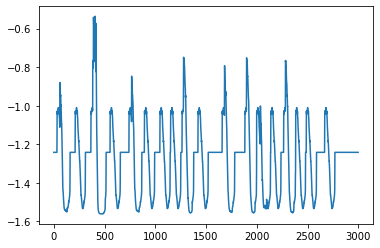

In [12]:
plt.plot(test_pred.cpu().detach().numpy()[:3000])

# Test

In [5]:
model = base_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model.load_state_dict(torch.load("/media/hdd01/sklee/tcn/baseTCN_CA1_sub6_i25700.pt"))
model = model.float().to("cuda")

#V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

V_ref = np.load("/media/hdd01/sklee/CA1_inputs/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")[:,:10000]
V_ref = V_ref.flatten()[:train_T+test_T]

test_V_ref = V_ref[train_T:train_T+test_T]


In [6]:
#E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
#I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

E_neural = np.load("/media/hdd01/sklee/CA1_inputs/Espikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]
I_neural = np.load("/media/hdd01/sklee/CA1_inputs/Ispikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()


0.9331701779329955


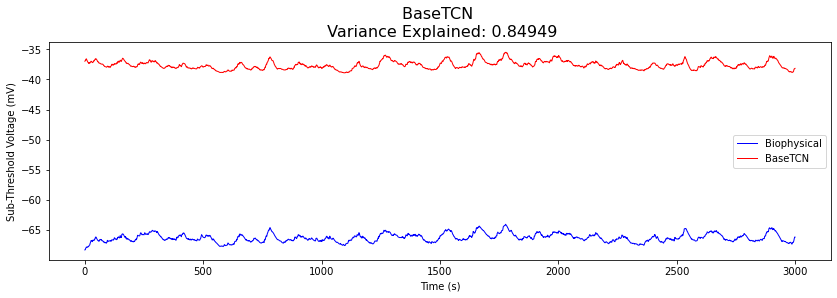

In [7]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-21,label="BaseTCN", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("BaseTCN \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/tcn/BaseTCN_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [8]:
#np.save("/media/hdd01/sklee/tcn/basetcn_CA1_sub6_test.npy", test_V_final)

In [9]:
e_weights = model.conv1_e_weights
e_bases = model.conv1_e_bases
e_prod = torch.matmul(e_weights, e_bases).cpu().detach().numpy()

i_weights = model.conv1_i_weights
i_bases = model.conv1_i_bases
i_prod = torch.matmul(i_weights, i_bases).cpu().detach().numpy()

for i in range(e_prod.shape[0]):
    e_prod[i] /= np.max(np.abs(e_prod[i]))
    i_prod[i] /= np.max(np.abs(i_prod[i]))
    e_prod[i] = np.flip(e_prod[i])
    i_prod[i] = np.flip(i_prod[i])

In [10]:
#np.save("/media/hdd01/sklee/tcn/basetcn_CA1_sub6_e_kern.npy", e_prod)
#np.save("/media/hdd01/sklee/tcn/basetcn_CA1_sub6_i_kern.npy", i_prod)